# SVM and Logistic Regression with PyTorch Implementation
In this exercise, we explore a machine learning framework called PyTorch. We will use the framework to implement SVM and Logistic Regression models and address a multi-class image classification problem.

# Submission
- There are four tasks for you.
- Report the results and answer the questions in a pdf file.
- Additionally, submit your code in the same Jupiter notebook format. (keep the overal format of the notebook unchanged)

In [1]:
# Hyperparameters for training a neural network on the MNIST dataset

# Learning rate controls the step size of gradient descent, determining how much to update the weights in each iteration.
learning_rate = 0.02

# Number of epochs specifies how many complete passes through the training dataset will be performed.
num_epochs = 100

# Batch size defines the number of images processed in each mini-batch during training.
batch_size = 32

# Percentage of the dataset to be used for training, allowing for experimentation with smaller subsets of data.
train_data_percentage = 0.0025
test_data_percentage = 0.1

# Input size corresponds to the dimensions of the MNIST images, flattened from 28x28 pixels.
input_size = 28 * 28  # MNIST image size

# Number of output classes, representing the digits 0 through 9 in the MNIST dataset.
num_classes = 10  # Number of classes in MNIST

In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

# Dataset characteristics
We use the MNIST digit classification data set for this assignment.
A total of 60K images for training and 10K images for testing are available. But we only use a small percentage of them. Images are 28 x 28 pixels.

In [3]:
# Load MNIST datasets, and create pytorch data loader to read data in mini-batches
def get_data_loaders(train_data_percentage, test_data_percentage, batch_size, transform):
  # Load the entire MNIST dataset
  # For train and test data points we sometimes use different transforms.
  # This becomes handy in the last task (data augmentation)
  full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_transform = transforms.Compose([transforms.ToTensor()])
  full_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)

  # Calculate the size based on the percentage
  train_size = int(train_data_percentage * len(full_train_dataset))  # percentage of training data
  test_size = int(test_data_percentage * len(full_test_dataset))    # percentage of test data
  train_remainder = len(full_train_dataset) - train_size
  test_remainder = len(full_test_dataset) - test_size

  # Split the dataset into the percentage specified and the remaining
  train_dataset, _ = random_split(full_train_dataset, [train_size, train_remainder])
  test_dataset, _ = random_split(full_test_dataset, [test_size, test_remainder])

  # Create DataLoaders for batching and shuffling
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

In [4]:
# Define transformation (convert to tensor)
transform = transforms.Compose([transforms.ToTensor()])
train_loader, test_loader = get_data_loaders(train_data_percentage, test_data_percentage,batch_size, transform)

In [5]:
# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).')

train_loader contains 5 batches of data.
train_image_batch has shape torch.Size([32, 1, 28, 28]),
where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).


# Visualization of the dataset

In [6]:
def show_gray_digits(image_set, row=2, col=3):
  # Here we visualize some of the data points in the data set.
  # Create a large figure, to be filled with multiple subplots.

  # Since image_set is a tensor variable, we transform it to a numpy type variable.
  image_set = image_set.cpu().detach().numpy()

  for i in range(row*col):
    # define subplot
    plt.subplot(row, col, i+1)
    # plot raw pixel data
    plt.imshow(image_set[i,0], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

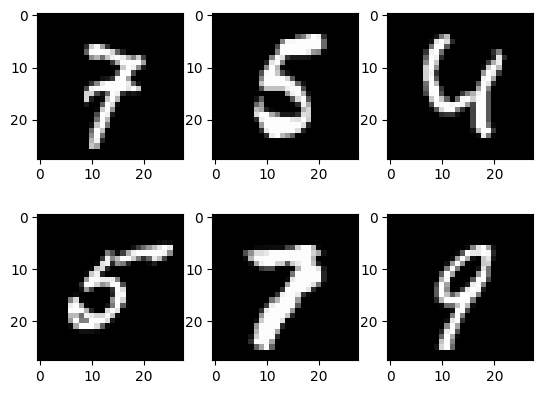

tensor([7, 5, 4, 5, 7, 9])


In [7]:
# display images and their corresponding labels.
show_gray_digits(train_image_batch, 2, 3)
print(classe_set[:6])

del train_image_batch, classe_set, train_loader, test_loader, transform

# Task 1: Linear SVM for MNIST classification (30 points).
In this part, you are provided with the implementation of a multi-class linear SVM model and the basic MNIST classfication workflow. Run the given code and try to understand how it works.

## Part A (5 points):

Is the implementation of the multi-class linear SVM similar to the end-to-end multiclass SVM that we learned in the class? Are there any significant differences?

## Part B (15 points):
1. Compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number and include it in the report (include only the plot in your report, not all the 2*100 numbers).

2. Compute the hinge loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number and include it in the report.(include only the plot in your report, not all the 2*100 numbers)

3. Report the **last** epoch results (including loss values and accuracies) for both train and test sets.

4. Does the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?

In [8]:
# Function to plot train/test loss and accuracy on separate subplots
def plot_eval_results(train_loss, test_loss, train_acc, test_acc):
  """
  Plots the training and testing loss/accuracy over the number of epochs.

  Parameters:
  - train_loss: list or array, the training loss values over epochs.
  - test_loss: list or array, the testing loss values over epochs.
  - train_acc: list or array, the training accuracy values over epochs.
  - test_acc: list or array, the testing accuracy values over epochs.
  """
  # Create subplots (1 row, 2 columns) for loss and accuracy
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # figsize sets the overall plot size

  # Plot Loss on the first subplot
  epochs = range(1, len(train_loss) + 1)
  ax1.plot(epochs, train_loss, 'b-', label='Training Loss'); ax1.plot(epochs, test_loss, 'r-', label='Test Loss');
  ax1.set_title('Loss vs. Epochs')
  ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss')
  ax1.legend(); ax1.grid(True)

  # Plot Accuracy on the second subplot
  ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy'); ax2.plot(epochs, test_loss, 'r-', label='Test Accuracy');
  ax2.set_title('Accuracy vs. Epochs')
  ax2.set_xlabel('Epochs'); ax2.set_ylabel('Accuracy (%)')
  ax2.legend(); ax2.grid(True)

  # Adjust layout to avoid subplot overlap
  plt.tight_layout(); plt.show()

In [9]:
# Define a linear SVM model
class LinearSVM(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.fc = nn.Linear(input_size, num_classes, bias=True)

  def forward(self, x):
    x= x.view(-1, input_size)
    return self.fc(x)

In [10]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_loader, test_loader = get_data_loaders(train_data_percentage, test_data_percentage, batch_size, transform)

In [11]:
# Return model loss and accuracy with the provided criterion and data_loader.
def eval(model, data_loader, criterion=None):
  model.eval()
  correct, total = 0, 0
  loss_batches = []

  # Switch to evaluation mode and turn off gradient calculation
  # since parameters are not updated during testing.
  with torch.no_grad():
    for images_batch, labels_batch in data_loader:
      outputs = model(images_batch)
      # The predicted label is the output with the highest activation.
      _, predicted = torch.max(outputs.data, 1)
      total += labels_batch.size(0)
      correct += (predicted == labels_batch).sum().item()

      # Use provided criterion to calculate the loss for the mini batch
      # Append the mini-batch loss to loss_batches array
      batch_loss = criterion(outputs, labels_batch)
      loss_batches.append(batch_loss.item())

  accuracy = 100 * correct / total
  loss = np.mean(loss_batches)

  model.train()

  return accuracy, loss

In [12]:
# Initialize the model, loss function, and optimizer
model = LinearSVM(input_size, num_classes)
criterion = nn.MultiMarginLoss()  # A Multi-class version of Hinge loss
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training the model
for epoch in range(num_epochs):
  for i, (images_batch, labels_batch) in enumerate(train_loader):
    optimizer.zero_grad() # Clear the gradients
    outputs = model(images_batch) # Forward pass
    loss = criterion(outputs, labels_batch) # Calculate loss
    loss.backward() # Backward pass
    optimizer.step() # Update weights

  # Obtain train/test loss values and accuracies after each epoch
  train_accuracy, train_loss = eval(model, train_loader, criterion)
  test_accuracy, test_loss = eval(model, test_loader, criterion)

  if (epoch + 1) % 20 == 0:  # Print every 20 epochs
    print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")

  train_loss_epochs.append(train_loss)
  test_loss_epochs.append(test_loss)
  train_accuracy_epochs.append(train_accuracy)
  test_accuracy_epochs.append(test_accuracy)

Epoch 20 - Train loss: 0.086379, Train accuracy: 94.00%
         - Test loss: 0.207407, Test accuracy: 76.80%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.039048, Train accuracy: 97.33%
         - Test loss: 0.174698, Test accuracy: 78.70%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.024279, Train accuracy: 98.67%
         - Test loss: 0.163662, Test accuracy: 79.60%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.017833, Train accuracy: 98.67%
         - Test loss: 0.158993, Test accuracy: 79.60%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.013806, Train accuracy: 100.00%
         - Test loss: 0.156939, Test accuracy: 79.80%
-------------------------------------------------------------


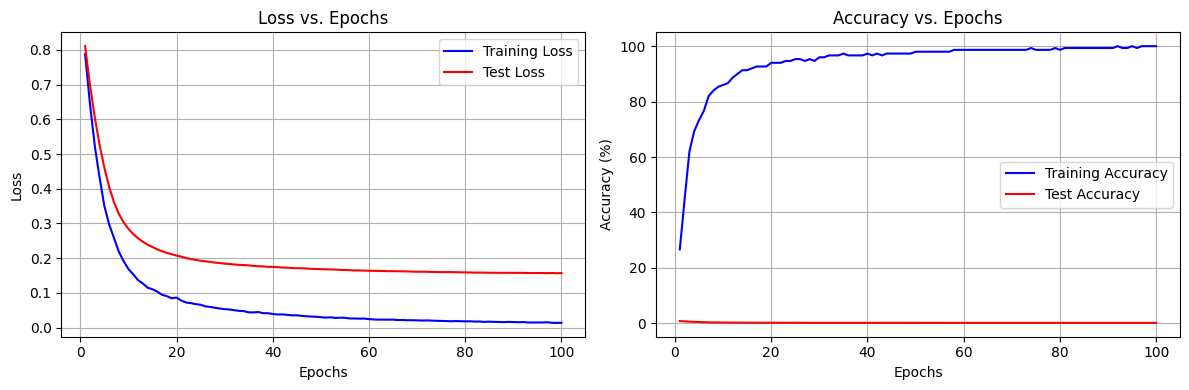

In [13]:
# Plotting
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

## Part C (10 points):

Weight decay works like regularization. Set weight decay to each of the values (0.1, 1, 10) during defining the SGD optimizer (see  [SGD optimizer documentation](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) for how to do that). Plot the train/test losses and accuracies per epoch. Also report the last epoch results (loss and accuracy for both train and test) . Does weight decay help in this case?Justify the results.



Training with weight decay = 0.1
Epoch 020 - Train loss: 0.0932, Train accuracy: 91.33%
          - Test loss: 0.2172, Test accuracy: 78.00%
-------------------------------------------------------------
Epoch 040 - Train loss: 0.0546, Train accuracy: 97.33%
          - Test loss: 0.1956, Test accuracy: 78.60%
-------------------------------------------------------------
Epoch 060 - Train loss: 0.0441, Train accuracy: 97.33%
          - Test loss: 0.1934, Test accuracy: 79.30%
-------------------------------------------------------------
Epoch 080 - Train loss: 0.0381, Train accuracy: 98.00%
          - Test loss: 0.1938, Test accuracy: 79.70%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.0351, Train accuracy: 98.00%
          - Test loss: 0.1949, Test accuracy: 79.70%
-------------------------------------------------------------


<Figure size 1500x500 with 0 Axes>

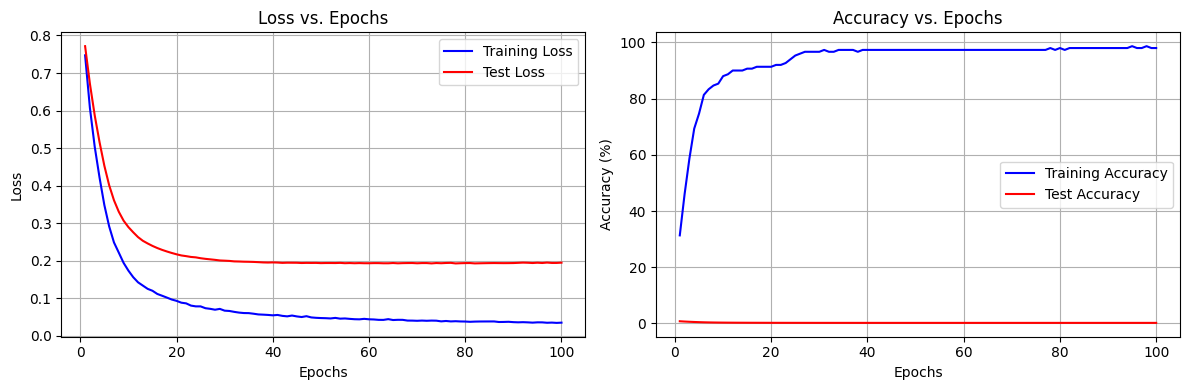


Training with weight decay = 1
Epoch 020 - Train loss: 0.2244, Train accuracy: 91.33%
          - Test loss: 0.3416, Test accuracy: 74.70%
-------------------------------------------------------------
Epoch 040 - Train loss: 0.2105, Train accuracy: 92.67%
          - Test loss: 0.3368, Test accuracy: 75.70%
-------------------------------------------------------------
Epoch 060 - Train loss: 0.2108, Train accuracy: 92.00%
          - Test loss: 0.3354, Test accuracy: 75.50%
-------------------------------------------------------------
Epoch 080 - Train loss: 0.2048, Train accuracy: 91.33%
          - Test loss: 0.3355, Test accuracy: 75.90%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.2096, Train accuracy: 92.67%
          - Test loss: 0.3359, Test accuracy: 75.90%
-------------------------------------------------------------


<Figure size 1500x500 with 0 Axes>

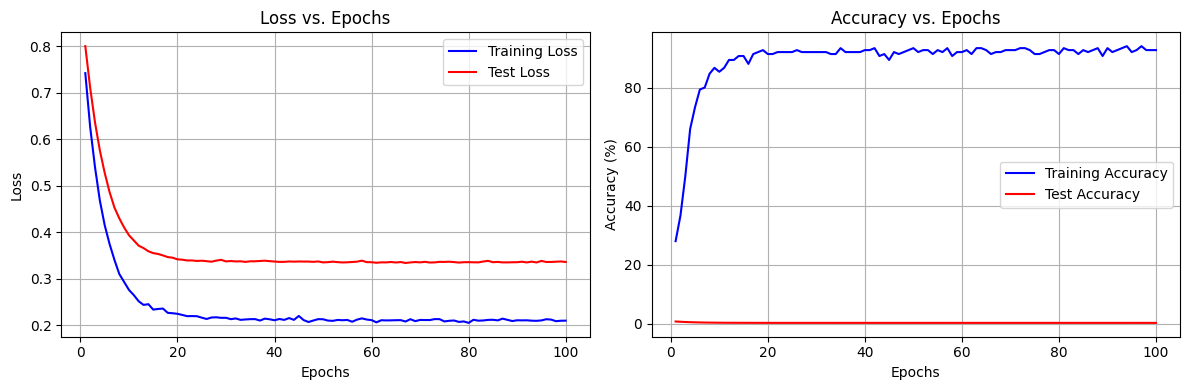


Training with weight decay = 10
Epoch 020 - Train loss: 0.7459, Train accuracy: 56.00%
          - Test loss: 0.7874, Test accuracy: 42.30%
-------------------------------------------------------------
Epoch 040 - Train loss: 0.7527, Train accuracy: 40.67%
          - Test loss: 0.7899, Test accuracy: 27.90%
-------------------------------------------------------------
Epoch 060 - Train loss: 0.7541, Train accuracy: 56.00%
          - Test loss: 0.7901, Test accuracy: 40.10%
-------------------------------------------------------------
Epoch 080 - Train loss: 0.7492, Train accuracy: 71.33%
          - Test loss: 0.7904, Test accuracy: 49.60%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.7525, Train accuracy: 53.33%
          - Test loss: 0.7909, Test accuracy: 37.90%
-------------------------------------------------------------


<Figure size 1500x500 with 0 Axes>

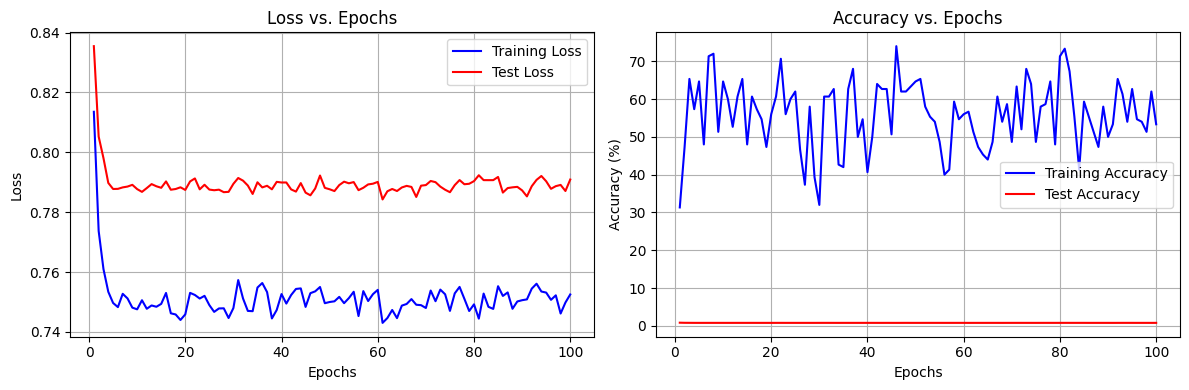


final results comparison:
weight decay   train loss    test loss    train acc     test acc
----------------------------------------------------------------------
         0.1       0.0351       0.1949       98.00%       79.70%
         1.0       0.2096       0.3359       92.67%       75.90%
        10.0       0.7525       0.7909       53.33%       37.90%


In [14]:
def train_with_weight_decay(weight_decay: int):
  model = LinearSVM(input_size, num_classes)
  criterion = nn.MultiMarginLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  train_loss_epochs = []
  test_loss_epochs = []
  train_accuracy_epochs = []
  test_accuracy_epochs = []

  # Training the model
  for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(images_batch)
      loss = criterion(outputs, labels_batch)
      loss.backward()
      optimizer.step()

    # Obtain train/test metrics after each epoch
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)

    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)

    if (epoch + 1) % 20 == 0:  # Print every 20 epochs
      print(f'Epoch {epoch+1:03d} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
      print(f'          - Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%')
      print("-------------------------------------------------------------")

  # Plot results
  plt.figure(figsize=(15, 5))
  plt.suptitle(f'Results with Weight Decay = {weight_decay}')

  plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

  # Return final epoch results
  return {
    'train_loss': train_loss_epochs[-1], 'test_loss': test_loss_epochs[-1],
    'train_accuracy': train_accuracy_epochs[-1], 'test_accuracy': test_accuracy_epochs[-1]
  }

weight_decay_values = [0.1, 1, 10]
results = {}

for wd in weight_decay_values:
  print(f"\nTraining with weight decay = {wd}")
  print("=" * 61)
  results[wd] = train_with_weight_decay(wd)

print("\nfinal results comparison:")
print("=" * 70)
print(f"{'weight decay':>12} {'train loss':>12} {'test loss':>12} {'train acc':>12} {'test acc':>12}")
print("-" * 70)
for wd in weight_decay_values:
  print(f"{wd:12.1f} {(r := results[wd])['train_loss']:12.4f} {r['test_loss']:12.4f} {r['train_accuracy']:11.2f}% {r['test_accuracy']:11.2f}%")

# Task 2: Logistic Regression for MNIST classification  (20 points).
In this part, you are asked to implement a logistic regression model for the same MNIST classfication problem.

## Part A (5 points):
Use Cross Entropy Loss (rather than Hinge Loss) to implement logistic regression.

In [15]:
# Logistic Regression model
class LogisticRegression(nn.Module):
  def __init__(self, input_size, num_classes):
    super().__init__()
    self.fc = nn.Linear(input_size, num_classes)

  def forward(self, x):
    x = x.view(-1, input_size)
    return self.fc(x)  # no need to apply sigmoid here


## Part B (10 points):
1. Compute the accuracy on the train and test set after each epoch in the training. Plot these accuracies as a function of the epoch number.

2. Compute the cross-entropy loss on the train and test set after each epoch in the training. Plot these loss values as a function of the epoch number.

3. Report the last epoch results (including loss values and accuracies) for both train and test sets.

4. Does the model shows significant overfitting? Or do you think there might be other factors that are more significant in the mediocre performance of the model?


Epoch 020 - Train loss: 2.2942, Train accuracy: 13.33%
          - Test loss: 2.2979, Test accuracy: 8.50%
-------------------------------------------------------------
Epoch 040 - Train loss: 2.2950, Train accuracy: 13.33%
          - Test loss: 2.2979, Test accuracy: 8.50%
-------------------------------------------------------------
Epoch 060 - Train loss: 2.2956, Train accuracy: 13.33%
          - Test loss: 2.2979, Test accuracy: 8.50%
-------------------------------------------------------------
Epoch 080 - Train loss: 2.2961, Train accuracy: 13.33%
          - Test loss: 2.2979, Test accuracy: 8.50%
-------------------------------------------------------------
Epoch 100 - Train loss: 2.2959, Train accuracy: 13.33%
          - Test loss: 2.2979, Test accuracy: 8.50%
-------------------------------------------------------------


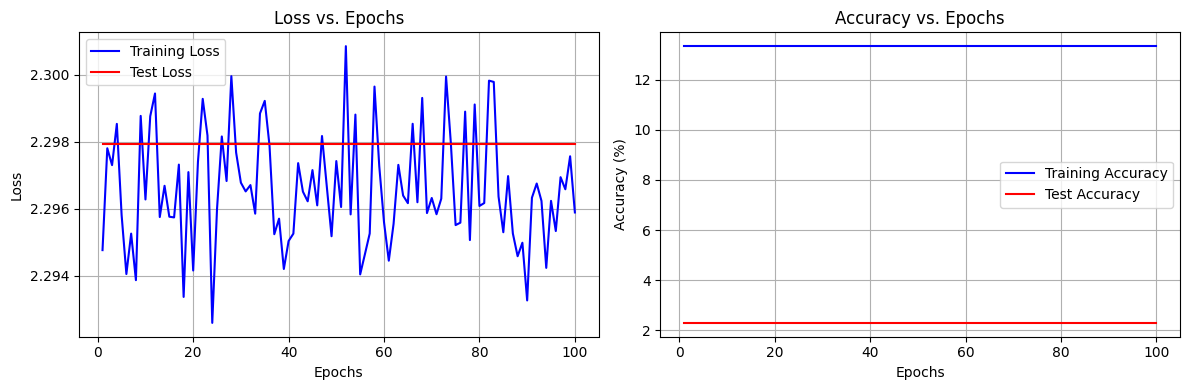

In [16]:
model = LogisticRegression(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimzer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training loop
for epoch in range(num_epochs):
  for i, (images_batch, labels_batch) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer.step()

  # Obtain train/test metrics after each epoch
  train_accuracy, train_loss = eval(model, train_loader, criterion)
  test_accuracy, test_loss = eval(model, test_loader, criterion)

  train_loss_epochs.append(train_loss)
  test_loss_epochs.append(test_loss)
  train_accuracy_epochs.append(train_accuracy)
  test_accuracy_epochs.append(test_accuracy)

  if (epoch + 1) % 20 == 0:  # Print every 20 epochs
    print(f'Epoch {epoch+1:03d} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.2f}%')
    print(f'          - Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.2f}%')
    print("-------------------------------------------------------------")
# Plot the results
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

## Part C (5 points)

Compare the results with SVM model. Does it work better, worse, or similar?

# Task 3: Non-linearity (30 points)



## Part A (20 points):

Add a hidden layer with 5000 neurons and a RELU layer for both logistic regression and SVM models in Task 1 and Task 2.
1. For both models, plot the train loss and the test loss.
2. For both models, plot the train and test accuracies.
3. For both models, report the loss and accuracy for both train and test sets.

## Part B (10 Points):

Compare the results with the linear model (without weight decay, to keep the comparison fair). Which approach works better? Why? Which appproach is more prone to overfitting? Explain your findings and justify it.

In [ ]:
# Run the ModifiedModel with Cross Entropy Loss (Logistic Regression)
class ModifiedLogisticModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    x = x.view(-1, input_size)
    x = self.fc1(x)
    x = self.relu(x)
    return self.fc2(x)

# Training parameters
learning_rate = 0.02
num_epochs = 100
batch_size = 32
hidden_size = 5000

# Initialize model and optimizer
model = ModifiedLogisticModel(input_size=28*28, hidden_size=hidden_size, num_classes=10)
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for logistic regression
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  for i, (images_batch, labels_batch) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  

  # Get training and test metrics
  train_accuracy, train_loss = eval(model, train_loader, criterion)
  test_accuracy, test_loss = eval(model, test_loader, criterion)
  
  # Store metrics
  train_loss_epochs.append(train_loss)
  test_loss_epochs.append(test_loss)
  train_accuracy_epochs.append(train_accuracy)
  test_accuracy_epochs.append(test_accuracy)
  
  if (epoch + 1) % 20 == 0:
    print(f'Epoch {epoch+1:03d}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    print('-' * 60)

# Plot results
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

Epoch 020:
Train Loss: 0.4576, Train Accuracy: 50.67%
Test Loss: 0.3318, Test Accuracy: 64.30%
------------------------------------------------------------
Epoch 040:
Train Loss: 0.3432, Train Accuracy: 51.33%
Test Loss: 0.2171, Test Accuracy: 71.30%
------------------------------------------------------------
Epoch 060:
Train Loss: 0.2498, Train Accuracy: 64.67%
Test Loss: 0.1927, Test Accuracy: 73.70%
------------------------------------------------------------
Epoch 080:
Train Loss: 0.2644, Train Accuracy: 59.33%
Test Loss: 0.1656, Test Accuracy: 76.20%
------------------------------------------------------------
Epoch 100:
Train Loss: 0.2249, Train Accuracy: 64.00%
Test Loss: 0.1566, Test Accuracy: 77.50%
------------------------------------------------------------


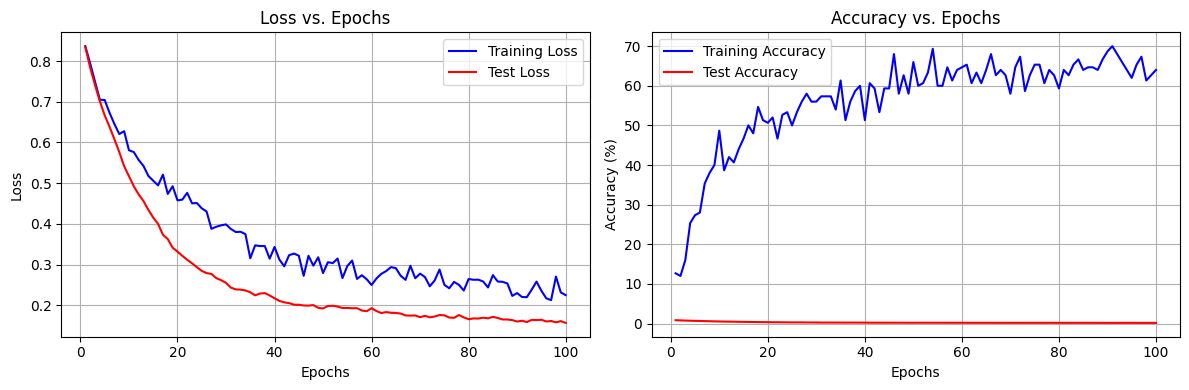

In [31]:
# Both the SVM and Logistic Regression models we have in Task 1 and 2
# can be changed to the ModifiedModel below.

# Modified model with added neurons and relu layer
class ModifiedModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    x = x.view(-1, input_size)
    x = self.fc1(x)
    x = self.relu(x)
    return self.fc2(x)

# Training parameters
learning_rate = 0.02
num_epochs = 100
batch_size = 32
hidden_size = 5000

# Initialize model and optimizer
model = ModifiedModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
criterion = nn.MultiMarginLoss()  # Hinge loss for SVM
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store metrics
train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  for i, (images_batch, labels_batch) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(images_batch)
    loss = criterion(outputs, labels_batch)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  # Get training and test metrics
  train_accuracy, train_loss = eval(model, train_loader, criterion)
  test_accuracy, test_loss = eval(model, test_loader, criterion)
  
  # Store metrics
  train_loss_epochs.append(train_loss)
  test_loss_epochs.append(test_loss)
  train_accuracy_epochs.append(train_accuracy)
  test_accuracy_epochs.append(test_accuracy)
  
  if (epoch + 1) % 20 == 0:
    print(f'Epoch {epoch+1:03d}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    print('-' * 60)

# Plot results
plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

# Task 4: Data Augmentation (20 points)

In this task, we will explore the concept of data augmentation, which is a powerful technique used to enhance the diversity of our training dataset without collecting new data. By applying various transformations to the original training images, we can create modified versions of these images.
We can then use these modified images to train our model with a "richer" set of examples.The use of data augmentation helps to improve the robustness and generalization of our models. Data augmentation is particularly beneficial in tasks like image classification, where we expect the model to be invariant to slight variations of images (e.g., rotation, cropping, blurring, etc.)

For this task, you are given a code that uses Gaussian Blur augmentation, which applies a Gaussian filter to slightly blur the images. If you run the code, you will see that this type of augmentation actually makes the model less accurate (compared with Task 3, SVM test accuracy)

For this task, you must explore other types of data augmentation and find one that improves the test accuracy by at least 1 percent compared with not using any augmentation (i.e., compared with Task 3, SVM test accuracy). Only change the augmentation approach, and keep the other parts of the code unchanged. Read the PyTorch documentation on different augmentation techniques [here](https://pytorch.org/vision/stable/transforms.html), and then try to identify a good augmentation method from them. Report the augmentation approach that you used, and explain why you think it helps. Also include train/test accuracy plots per epoch, and the train/test accuracy at the final epoch.

In [46]:
def run_loop(augmentation,
             lr=learning_rate, momentum=0, nesterov=False,
             scheduler=False, scheduler_kwargs=None,
             gradient_clipping=False):
  train_loader, test_loader = get_data_loaders(train_data_percentage, test_data_percentage, batch_size, augmentation)
  
  # Run the ModifiedModel with Hinge Loss (SVM)
  # Model initialization
  model = ModifiedModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)
  criterion = nn.MultiMarginLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

  if scheduler:
    scheduler_kwargs=scheduler_kwargs or {}
    S=optim.lr_scheduler.ReduceLROnPlateau(optimizer, **{"mode":"min","factor":0.5, "patience":5, "min_lr":0.001, **scheduler_kwargs})
  
  train_loss_epochs = []
  test_loss_epochs = []
  train_accuracy_epochs = []
  test_accuracy_epochs = []
  
  # Training
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    
    for i, (images_batch, labels_batch) in enumerate(train_loader):
      optimizer.zero_grad()
      outputs = model(images_batch)
      loss = criterion(outputs, labels_batch)
      loss.backward()

      if gradient_clipping: nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      
      optimizer.step()
      running_loss += loss.item()
      num_batches += 1

    avg_training_loss = running_loss/num_batches
    # Get training and test metrics
    train_accuracy, train_loss = eval(model, train_loader, criterion)
    test_accuracy, test_loss = eval(model, test_loader, criterion)

    if scheduler: S.step(test_loss)
    
    # Store metrics
    train_loss_epochs.append(train_loss)
    test_loss_epochs.append(test_loss)
    train_accuracy_epochs.append(train_accuracy)
    test_accuracy_epochs.append(test_accuracy)
    
    if (epoch + 1) % 20 == 0:
      print(f'Epoch {epoch+1:02d} - Train loss: {train_loss:.6f}, Train accuracy: {train_accuracy:.2f}%')
      print(f'         - Test loss: {test_loss:.6f}, Test accuracy: {test_accuracy:.2f}%')
      print(f'         - Avg training loss: {avg_training_loss:.6f}%')
      print("-------------------------------------------------------------")
        
  # Plot the loss values and accuracies for train/test
  plot_eval_results(train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs)

Epoch 20 - Train loss: 0.419152, Train accuracy: 50.00%
         - Test loss: 0.336431, Test accuracy: 58.10%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.285088, Train accuracy: 58.67%
         - Test loss: 0.203556, Test accuracy: 71.50%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.248359, Train accuracy: 64.67%
         - Test loss: 0.170858, Test accuracy: 74.50%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.187828, Train accuracy: 68.00%
         - Test loss: 0.151827, Test accuracy: 76.00%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.220293, Train accuracy: 64.00%
         - Test loss: 0.143792, Test accuracy: 76.60%
-------------------------------------------------------------


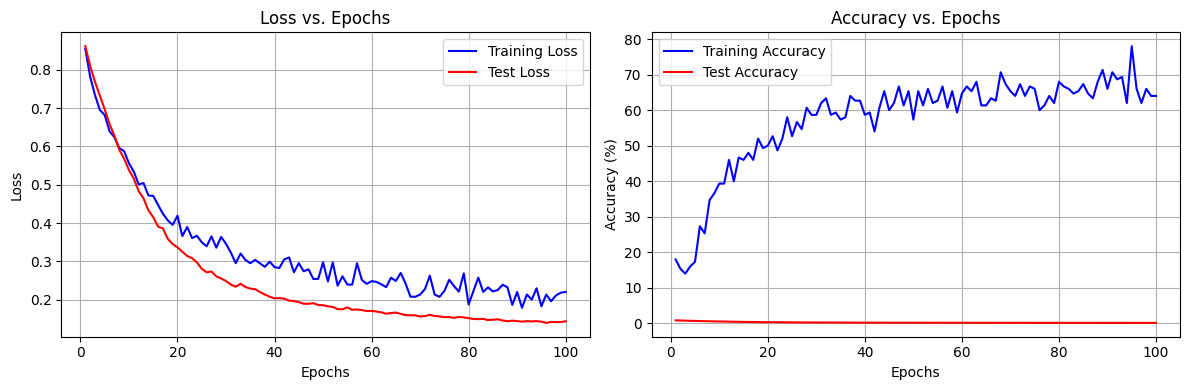

In [23]:
# r1: pretty noisy
augmentation = transforms.Compose([
    # Convert to tensor first (scales pixels to [0,1])
    transforms.ToTensor(),
    # Random rotation (-10 to 10 degrees) - helps with digit orientation variation
    transforms.RandomRotation(degrees=10, fill=0),
    # Random affine transformation for slight shearing/translation
    transforms.RandomAffine(
        degrees=0,  # no rotation in affine since we already have RandomRotation
        translate=(0.1, 0.1),  # allow small translations
        scale=(0.9, 1.1),  # slight scaling
        shear=5,  # slight shearing
        fill=0
    ),
    # Randomly adjust brightness and contrast
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5)
])
run_loop(augmentation)

Epoch 20 - Train loss: 0.140770, Train accuracy: 87.33%
         - Test loss: 0.234444, Test accuracy: 73.70%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.072556, Train accuracy: 94.00%
         - Test loss: 0.181798, Test accuracy: 75.80%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.054841, Train accuracy: 96.00%
         - Test loss: 0.165705, Test accuracy: 76.60%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.037765, Train accuracy: 96.67%
         - Test loss: 0.156849, Test accuracy: 77.40%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.039269, Train accuracy: 96.00%
         - Test loss: 0.148817, Test accuracy: 77.50%
-------------------------------------------------------------


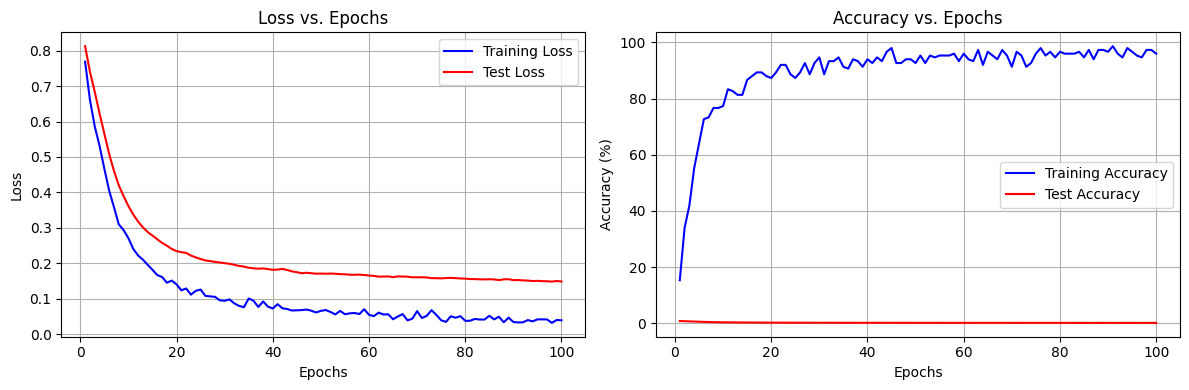

In [26]:
# r2: adjust with random rotation, use random erasing, and remove affine (too much instability)
augmentation = transforms.Compose([
    # Start with small random rotation (just ±5 degrees to keep digits readable)
    transforms.RandomRotation(degrees=5, fill=0),
    # Add a very slight random perspective for depth variation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=0),
    # Convert to tensor (scales to [0,1])
    transforms.ToTensor(),
    # Add slight random erasing (simulates noise/occlusion)
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
])
run_loop(augmentation)

Epoch 20 - Train loss: 0.102925, Train accuracy: 94.67%
         - Test loss: 0.229706, Test accuracy: 73.60%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.050816, Train accuracy: 96.67%
         - Test loss: 0.177065, Test accuracy: 77.00%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.028569, Train accuracy: 98.67%
         - Test loss: 0.161769, Test accuracy: 77.30%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.032035, Train accuracy: 98.67%
         - Test loss: 0.151054, Test accuracy: 77.90%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.023273, Train accuracy: 100.00%
         - Test loss: 0.141966, Test accuracy: 79.30%
-------------------------------------------------------------


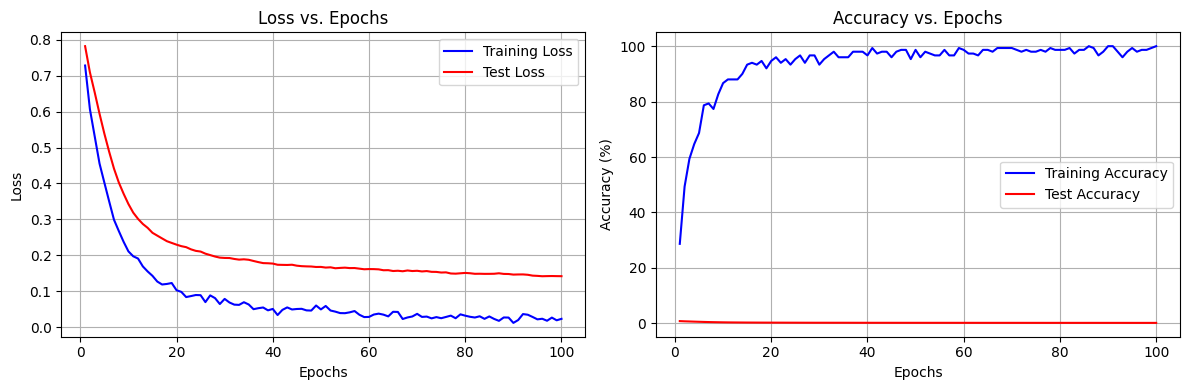

In [33]:
# r3: this one, we modify some rotation angle
augmentation = transforms.Compose([
    # Small random rotation with higher probability of small angles
    transforms.RandomRotation(degrees=3, fill=0),  # Even more conservative rotation
    # Very subtle random perspective
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3, fill=0),
    # Convert to tensor
    transforms.ToTensor(),
    # Extremely subtle random noise
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3)
])
run_loop(augmentation)

Epoch 20 - Train loss: 0.043723, Train accuracy: 100.00%
         - Test loss: 0.300465, Test accuracy: 78.90%
         - Avg training loss: 0.057886%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.018167, Train accuracy: 98.00%
         - Test loss: 0.235728, Test accuracy: 80.50%
         - Avg training loss: 0.035170%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.022512, Train accuracy: 96.67%
         - Test loss: 0.209385, Test accuracy: 81.00%
         - Avg training loss: 0.018108%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.014044, Train accuracy: 98.67%
         - Test loss: 0.195950, Test accuracy: 81.50%
         - Avg training loss: 0.018437%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.011588, Train accuracy: 100.00%
         - Test loss: 0.188450, Test accuracy: 80.60%
         - Avg training loss: 0.017338%

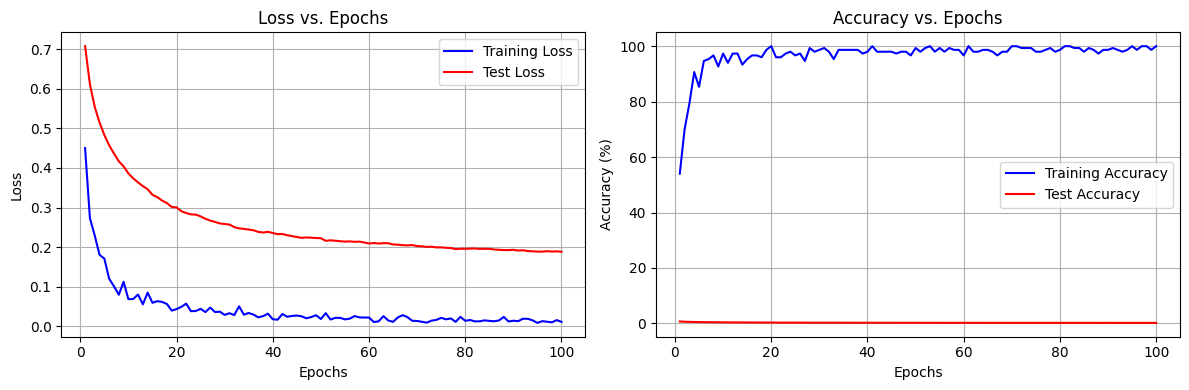

In [41]:
# r4: r3, but, we add normalisation to MNIST mean and std for training stability [PICK THIS]
A = augmentation = transforms.Compose([
    # Small random rotation with higher probability of small angles
    transforms.RandomRotation(degrees=3, fill=0),  # Even more conservative rotation
    # Very subtle random perspective
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3, fill=0),
    # Convert to tensor
    transforms.ToTensor(),
    # Normalize to improve training stability
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
    # Extremely subtle random noise
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3)
])
run_loop(augmentation)

Epoch 20 - Train loss: 0.055497, Train accuracy: 97.33%
         - Test loss: 0.314913, Test accuracy: 74.60%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.041043, Train accuracy: 97.33%
         - Test loss: 0.255832, Test accuracy: 76.30%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.025230, Train accuracy: 98.00%
         - Test loss: 0.222288, Test accuracy: 80.00%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.025709, Train accuracy: 98.67%
         - Test loss: 0.206642, Test accuracy: 79.20%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.021311, Train accuracy: 98.00%
         - Test loss: 0.192393, Test accuracy: 80.10%
-------------------------------------------------------------


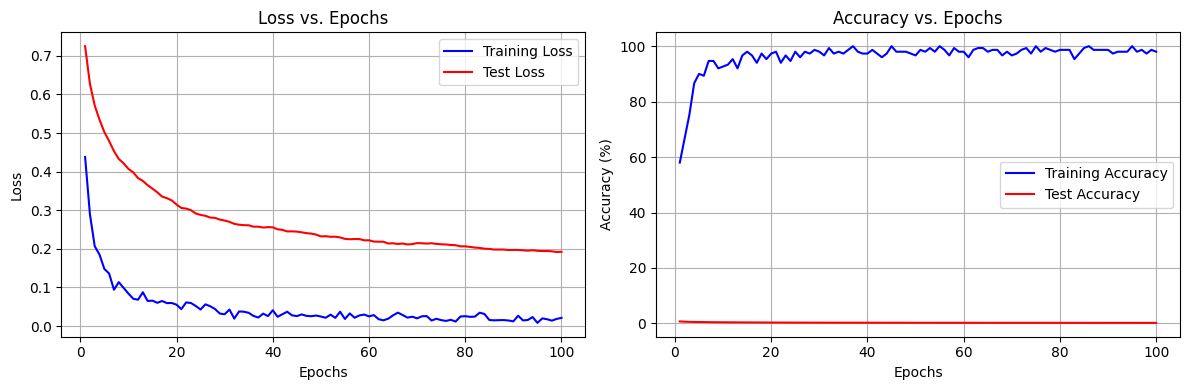

In [37]:
# r4.1: r4, but we add RandomErasing to help with robustness to noise and partial occlusion
augmentation = transforms.Compose([
    # Small random rotation with higher probability of small angles
    transforms.RandomRotation(degrees=3, fill=0),  # Even more conservative rotation
    # Very subtle random perspective
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3, fill=0),
    # Convert to tensor
    transforms.ToTensor(),
    # Normalize to improve training stability
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
    # some noise and partial occlusion
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
    # Extremely subtle random noise
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3)
])
run_loop(augmentation)

Epoch 20 - Train loss: 0.006680, Train accuracy: 98.67%
         - Test loss: 0.147720, Test accuracy: 80.60%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.005446, Train accuracy: 99.33%
         - Test loss: 0.134519, Test accuracy: 81.60%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.004117, Train accuracy: 99.33%
         - Test loss: 0.127371, Test accuracy: 82.40%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.002433, Train accuracy: 100.00%
         - Test loss: 0.124401, Test accuracy: 83.30%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.004279, Train accuracy: 100.00%
         - Test loss: 0.124045, Test accuracy: 82.40%
-------------------------------------------------------------


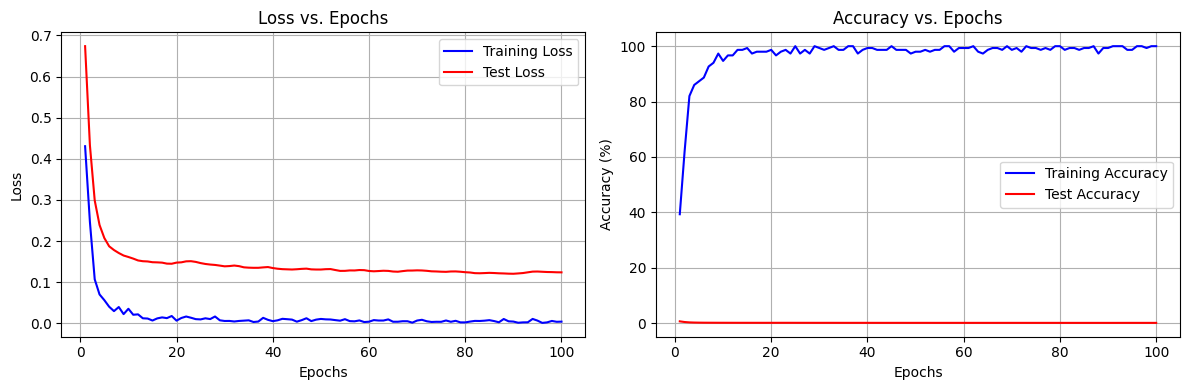

In [36]:
# r4.2: Just for fun, but we set momentum to 0.9 with slightly lower learning rate
augmentation = transforms.Compose([
    # Small random rotation with higher probability of small angles
    transforms.RandomRotation(degrees=3, fill=0),  # Even more conservative rotation
    # Very subtle random perspective
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3, fill=0),
    # Convert to tensor
    transforms.ToTensor(),
    # Normalize to improve training stability
    transforms.Normalize((0.1307,), (0.3081,)),  # MNIST mean and std
    # Extremely subtle random noise
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.3)
])
run_loop(augmentation, lr=0.01, momentum=0.9)

Epoch 20 - Train loss: 0.107319, Train accuracy: 90.67%
         - Test loss: 0.259959, Test accuracy: 70.60%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.054354, Train accuracy: 95.33%
         - Test loss: 0.208952, Test accuracy: 73.00%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.034770, Train accuracy: 97.33%
         - Test loss: 0.187900, Test accuracy: 75.00%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.021187, Train accuracy: 98.00%
         - Test loss: 0.178431, Test accuracy: 75.90%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.013640, Train accuracy: 99.33%
         - Test loss: 0.172885, Test accuracy: 76.40%
-------------------------------------------------------------


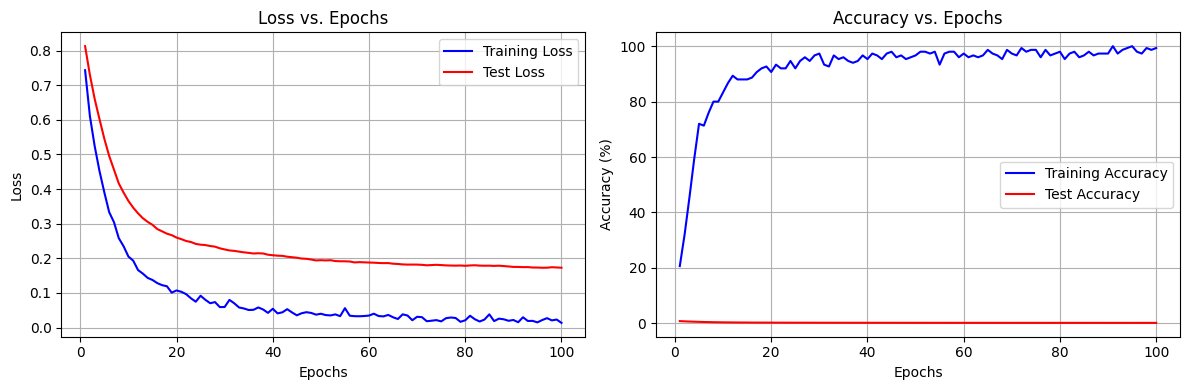

In [35]:
# r5: This one, we add gaussian blur randomly and slight translation
augmentation = transforms.Compose([
    # Convert to tensor first
    transforms.ToTensor(),
    
    # Add slight random noise to make model more robust
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.2))
    ], p=0.3),
    
    # Slight random rotation (very conservative)
    transforms.RandomRotation(degrees=2, fill=0),
    
    # Slight random translation
    transforms.RandomAffine(
        degrees=0,  # no rotation in affine since we already have RandomRotation
        translate=(0.02, 0.02),  # very small translations
        fill=0
    )
])
run_loop(augmentation)

---
### Outside: Can we improve this?

Probably, let's add scheduler and enable nesterov

Epoch 20 - Train loss: 0.023334, Train accuracy: 97.33%
         - Test loss: 0.172207, Test accuracy: 80.50%
         - Avg training loss: 0.014928%
-------------------------------------------------------------
Epoch 40 - Train loss: 0.010225, Train accuracy: 98.00%
         - Test loss: 0.146240, Test accuracy: 82.30%
         - Avg training loss: 0.009729%
-------------------------------------------------------------
Epoch 60 - Train loss: 0.003146, Train accuracy: 100.00%
         - Test loss: 0.137334, Test accuracy: 82.60%
         - Avg training loss: 0.004985%
-------------------------------------------------------------
Epoch 80 - Train loss: 0.005717, Train accuracy: 99.33%
         - Test loss: 0.134019, Test accuracy: 82.50%
         - Avg training loss: 0.003837%
-------------------------------------------------------------
Epoch 100 - Train loss: 0.003667, Train accuracy: 100.00%
         - Test loss: 0.134545, Test accuracy: 82.60%
         - Avg training loss: 0.016699%

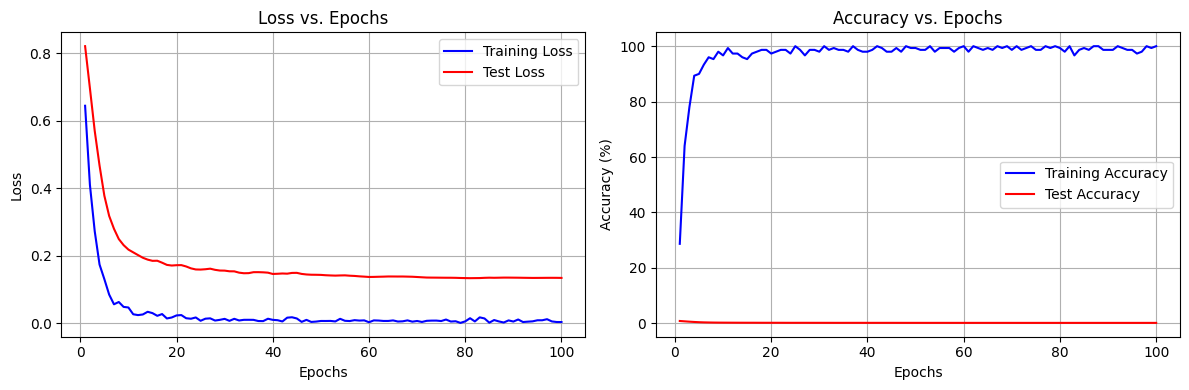

In [48]:
run_loop(A, lr=0.01, momentum=0.9, nesterov=True, scheduler=True, gradient_clipping=True)